# Specifying priors

This tutorial demonstrates how to specify parameter priors, including:

* uniform and log-uniform distributions
* gaussian and more complicated distributions
* multi-dimensional priors (not factorized)
* non-analytic priors
* priors on fractions

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

## Cumulative prior distributions

Any 1-dimensional probability distribution is normalised so that its integral is 1. That is, the cumulative distribution goes from 0 to 1. For example:

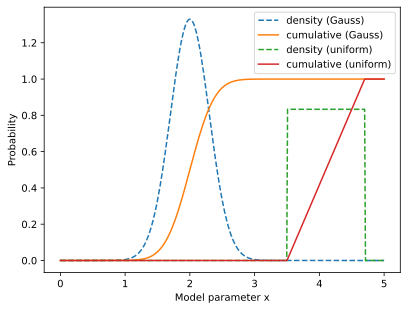

In [2]:
gaussdistribution = scipy.stats.norm(2, 0.3)
uniformdistribution = scipy.stats.uniform(3.5, 1.2)
x = np.linspace(0, 5, 400)
plt.figure()
plt.plot(x, gaussdistribution.pdf(x), '--', label='density (Gauss)')
plt.plot(x, gaussdistribution.cdf(x), label='cumulative (Gauss)')
plt.plot(x, uniformdistribution.pdf(x), '--', label='density (uniform)')
plt.plot(x, uniformdistribution.cdf(x), label='cumulative (uniform)')
plt.ylabel('Probability')
plt.xlabel('Model parameter x')
plt.legend();

## Transforming from the unit interval

We invert the cumulative probability distribution mapping quantiles (0...1) to the corresponding model parameter value.

Lets start with the uniform distribution.

In [3]:
def transform_1d_uniform(quantile):
    lower_bound = 3.5
    width = 1.2
    return quantile * width + lower_bound
    

Scipy provides the inverse cumulative probability distributions:

In [4]:
def transform_1d(quantile):
    return gaussdistribution.ppf(quantile)


UltraNest samples from the unit interval to obtain prior samples. Lets try drawing a few examples from our function:

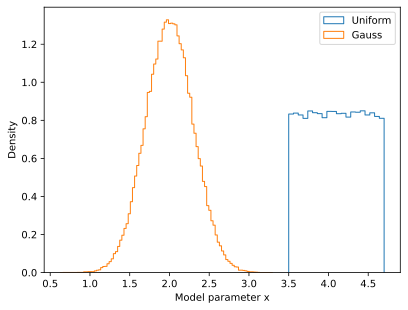

In [5]:
uniform_samples = transform_1d_uniform(np.random.uniform(0, 1, size=100000))
gauss_samples = transform_1d(np.random.uniform(0, 1, size=100000))
plt.figure()
plt.hist(uniform_samples, bins=20, histtype='step', density=True, label='Uniform')
plt.hist(gauss_samples, bins=100, histtype='step', density=True, label='Gauss')
plt.xlabel('Model parameter x')
plt.ylabel('Density')
plt.legend();

Beautiful! We obtained nice samples that follow the prior distribution.

## The unit hypercube

Lets specify a prior for UltraNest with multiple parameters:

* a uniform distribution from 3.5 to 4.7
* a log-uniform distribution from 0.01 to 100
* a gaussian distribution around 2.0 +- 0.3


In [6]:
# out transform function will receive one quantile corresponding to each of the three parameter
def transform(quantile_cube):
    # prepare the output array, which has the same shape
    transformed_parameters = np.empty_like(quantile_cube)
    # first parameter: a uniform distribution
    transformed_parameters[0] = 3.5 + 1.2 * quantile_cube[0]
    # second parameter: a log-uniform distribution
    transformed_parameters[1] = 10**(-2 + 4 * quantile_cube[1])
    # third parameter: Gaussian
    transformed_parameters[2] = mydistribution.ppf(quantile_cube[2])
    
    return transformed_parameters

Some recommendations:

* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) provides many 1-d distributions that can be used like this.
* avoid building scipy.stats objects in the transform, because this is slow -- build them outside first, then only invoke the .ppf method in the transform.


## Dependent priors

In some cases, a previous experiment gives informative priors which we want to incorporate, and they may be inter-dependent. For example, consider a two-dimensional gaussian prior distribution:


In [7]:
means = np.array([2, 3])
cov = np.array([[1, 0.6], [0.6, 0.4]])

Text(0, 0.5, 'Parameter 2')

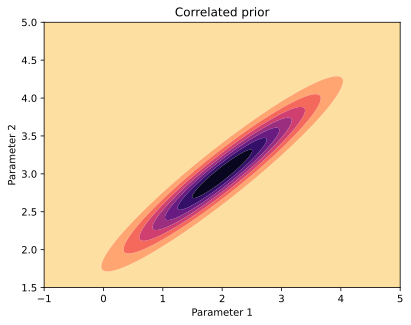

In [8]:
rv = scipy.stats.multivariate_normal(means, cov)
x, y = np.linspace(-1, 5, 400), np.linspace(1.5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = rv.pdf(np.transpose([X.flatten(), Y.flatten()])).reshape(X.shape)
plt.figure()
plt.title('Correlated prior')
plt.contourf(X, Y, Z, cmap='magma_r')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2');

We recall:

* Parameter 1 has a cumulative distribution
* At each value of Parameter 1, Parameter 2 has a cumulative distribution.
* We can thus specify a dependent distribution using the unit hypercube

In [9]:
a = np.linalg.inv(cov)
l, v = np.linalg.eigh(a)
rotation_matrix = np.dot(v, np.diag(1. / np.sqrt(l)))

def transform_correlated(quantiles):
    # sample a independent multivariate gaussian
    independent_gaussian = scipy.stats.norm.ppf(quantiles)
    # rotate and shift
    return means + np.einsum('ij,kj->ki', rotation_matrix, independent_gaussian)

Lets try sampling!

Text(0, 0.5, 'Parameter 2')

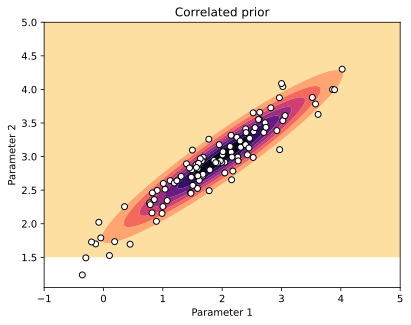

In [10]:
samples = transform_correlated(np.random.uniform(0, 1, size=(100, 2)))

plt.figure()
plt.title('Correlated prior')
plt.contourf(X, Y, Z, cmap='magma_r')
plt.plot(samples[:,0], samples[:,1], 'o', mew=1, mfc='w', mec='k')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2');


A similar effect can be achieved by defining transforms in sequence (this is a different prior though):

In [11]:
gauss1 = scipy.stats.norm(2, 1)
gauss2 = scipy.stats.norm(0, 0.1)


def transform_correlated(quantiles):
    parameters = np.empty_like(quantiles)
    # first parameter is independent
    parameters[0] = gauss1.ppf(quantiles[0])
    # second parameter depends on first parameter, here with a shift
    parameters[1] = parameters[0] + gauss2.ppf(quantiles[0])
    return parameters

## Non-analytic priors

Sometimes, the prior may not be easily invertable. For example, when it is given as posterior samples from a previous analysis. I



(array([ 27.,  26.,  25.,  18.,  25.,  25.,  21.,  27.,  25.,  23.,  15.,
         21.,  22.,  20.,  17.,  31.,  20.,  33.,  29.,  20.,  22.,  20.,
         23.,  27.,  25.,  27.,  25.,  24.,  24.,  18.,  16.,  36.,  20.,
         22.,  23.,  36.,  30.,  22.,  23.,  19.,  25.,  32.,  17.,  30.,
         15.,  21.,  19.,  23.,  27.,  26.,  32.,  21.,  15.,  25.,  31.,
         20.,  16.,  29.,  21.,  25.,  21.,  37.,  17.,  24.,  32.,  30.,
         19.,  25.,  32.,  32.,  33.,  39.,  42.,  57.,  59.,  79.,  97.,
        108., 120., 130., 143., 162., 177., 144., 155., 133., 128., 100.,
         89.,  86.,  57.,  50.,  42.,  26.,  22.,  13.,   5.,   5.,   5.,
          3.]),
 array([9.52203625e-04, 3.69641993e-02, 7.29761951e-02, 1.08988191e-01,
        1.45000187e-01, 1.81012182e-01, 2.17024178e-01, 2.53036174e-01,
        2.89048169e-01, 3.25060165e-01, 3.61072161e-01, 3.97084157e-01,
        4.33096152e-01, 4.69108148e-01, 5.05120144e-01, 5.41132139e-01,
        5.77144135e-01, 6.1315

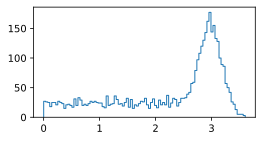

In [12]:
posterior_samples = np.hstack((np.random.uniform(0, 3, 2000), np.random.normal(3, 0.2, 2000)))

plt.figure(figsize=(4,2))
plt.hist(posterior_samples, histtype='step', bins=100);


In this case, you can compute the cumulative distribution numerically and invert it:

(array([0.51072442, 0.08512074, 0.11349432, 0.14186789, 0.02837358,
        0.14186789, 0.11349432, 0.25536221, 0.25536221, 0.17024147,
        0.02837358, 0.14186789, 0.14186789, 0.08512074, 0.31210937,
        0.17024147, 0.08512074, 0.11349432, 0.19861505, 0.25536221,
        0.11349432, 0.08512074, 0.11349432, 0.25536221, 0.17024147,
        0.31210937, 0.22698863, 0.08512074, 0.05674716, 0.22698863,
        0.11349432, 0.08512074, 0.08512074, 0.14186789, 0.19861505,
        0.31210937, 0.14186789, 0.25536221, 0.19861505, 0.14186789,
        0.17024147, 0.17024147, 0.17024147, 0.17024147, 0.11349432,
        0.14186789, 0.19861505, 0.25536221, 0.19861505, 0.11349432,
        0.14186789, 0.22698863, 0.08512074, 0.17024147, 0.36885653,
        0.14186789, 0.11349432, 0.19861505, 0.25536221, 0.28373579,
        0.19861505, 0.19861505, 0.22698863, 0.11349432, 0.19861505,
        0.39723011, 0.11349432, 0.17024147, 0.17024147, 0.11349432,
        0.36885653, 0.22698863, 0.28373579, 0.28

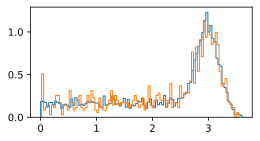

In [13]:
hist, bin_edges = np.histogram(posterior_samples, bins=100)
hist_cumulative = np.cumsum(hist / hist.sum())
bin_middle = (bin_edges[:-1] + bin_edges[1:]) / 2

def transform_histogram(quantile):
    return np.interp(quantile, hist_cumulative, bin_middle)

samples = transform_histogram(np.random.uniform(size=1000))
plt.figure(figsize=(4,2))
plt.hist(posterior_samples, histtype='step', bins=100, density=True);
plt.hist(samples, histtype='step', bins=100, density=True);


## Fraction parameters

Some parameters such as fractions (or abundances) may be required to sum to 1. How can we specify such parameters?

One option is to use absolute numbers. For example, instead of specifying the total mass and mass fractions for each chemical element, parameterise the mass of each element. This avoids the <=1 constraint, and may be easier to infer. A drawback is that the prior ranges for each element mass may be wide.

The other option is to use the right distribution exactly made for this, which samples unbiased under the constraint (sum<=1): The [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Here we assume that the prior on the individual fraction is flat (flat Dirichlet distribution, $\alpha=1$).


In [14]:
def transform_dirichlet(quantiles):
    # https://en.wikipedia.org/wiki/Dirichlet_distribution#Random_number_generation
    # first inverse transform sample from Gamma(alpha=1,beta=1), which is Exponential(1)
    gamma_quantiles = -np.log(quantiles)
    # dirichlet variables
    return gamma_quantiles / gamma_quantiles.sum(axis=1).reshape((-1, 1))


Lets have a look at the samples:

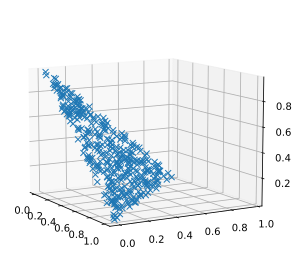

In [15]:
samples = transform_dirichlet(np.random.uniform(0, 1, size=(400, 3)))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=-30)
ax.plot(samples[:,0], samples[:,1], samples[:,2], 'x ');

The samples nicely lie on the plane where the sum is 1.

##  Further topics

Check out the rest of the documentation and the tutorials.

They illustrate how to:

* [speeding up transforms with vectorisation](https://johannesbuchner.github.io/UltraNest/performance.html)
* [How to use priors in Ultranest](https://johannesbuchner.github.io/UltraNest/usage-spectral-line.html)
* and many example tutorials